








     
     
     
     
     
     I compared the ICRF3 S/X catalog with the Gaia DR2 catalog (iers_auxilary).

In [1]:
from astropy.table import Table, join, Column
from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# My modules
from my_progs.catalog.vsh_deg1_cor import vsh_deg01_fitting
from my_progs.catalog.vsh_deg2_cor import vsh_deg02_fitting, residual_calc02
from my_progs.catalog.pos_diff import nor_sep_calc, pos_diff_calc
from my_progs.catalog.pos_err import pos_err_calc
from my_progs.catalog.write_output import print_vsh1_corr, print_vsh2_corr
from my_progs.stat_func.rms_calc import rms_calc

Load the positional information from these two catalogs.

In [2]:
# Read ICRF3 S/X catalog
from my_progs.catalog.read_icrf import read_icrf3
icrf3 = read_icrf3(wv="sx")

# Read Gaia DR2 IERS quasar data
from my_progs.catalog.read_gaia import read_dr2_iers

gaiadr2 = read_dr2_iers()

A crossmatch is performed to obtain a sample of common sources.

In [3]:
com_sou = join(icrf3, gaiadr2, keys="iers_name", table_names=["icrf3sx", "gaiadr2"])
com_sou

<Table masked=True length=2820>
   icrf_name     iers_name type ... phot_bp_mean_mag phot_rp_mean_mag
                                ...       mag              mag       
     str16          str8   str1 ...     float32          float32     
---------------- --------- ---- ... ---------------- ----------------
J000318.6-192722  0000-197   -- ...        19.635006        18.525171
J000315.9-194150  0000-199   -- ...        19.314455         18.64363
J000416.1+461517  0001+459   -- ...        20.788141        19.799097
J000404.9-114858  0001-120   -- ...         19.66084        18.616665
J000520.2+052410  0002+051   -- ...        16.325563        15.677205
J000504.3+542824  0002+541   -- ...        18.719727         17.97392
J000517.9-164804  0002-170   -- ...          17.8112        17.465117
J000435.6-473619  0002-478    D ...        19.998808        19.225542
J000623.0+123553  0003+123   -- ...         16.58037        16.094025
             ...       ...  ... ...              ...              ...
J235816.9-285334  2355-291   -- ...         19.17362        18.058022
J235753.2-531113  2355-534    D ...        18.973099        18.330183
J235846.0+195520  2356+196   -- ...        17.926826        17.538961
J235933.1+385042  2356+385    D ...        19.181053        18.476099
J235859.8+392228  2356+390   -- ...         20.39755        19.513962
J235931.8-063943  2356-069   -- ...        18.141775        17.668432
J235935.4-313343  2357-318   -- ...        19.466673        18.695164
J000020.3-322101  2357-326   -- ...        18.252312        17.669233
J000105.3-155107  2358-161   -- ...        18.379673        17.891047
J000211.9-215309  2359-221   -- ...        19.407907         17.85715

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


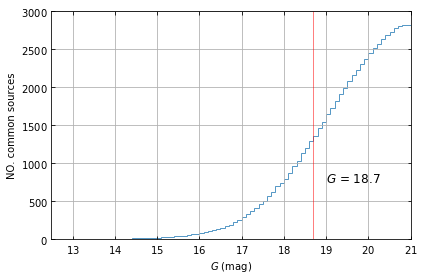

In [4]:
fig, ax = plt.subplots()

bins_array = np.arange(12.5, 21.1, 0.1)

ax.hist(com_sou["phot_g_mean_mag"], bins_array, histtype="step", alpha=0.75,
       cumulative=True)
ax.vlines(18.7, 0, 3000, lw=0.5, color="r")

ax.text(19, 750, "$G$ = 18.7", fontsize=12)

ax.axis([12.5, 21, 0, 3000])

ax.grid()
ax.set_xlabel("$G$ (mag)")
ax.set_ylabel("NO. common sources")

ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")

fig.tight_layout()
plt.savefig("../plots/comsou-g_icrf3sx_gaiadr2.eps")

In [5]:
tmp = Table(com_sou)
tmp.sort("phot_g_mean_mag")
print("The 100th source corresponds to g={:.2f} mag".format(tmp[99]["phot_g_mean_mag"]))

The 100th source corresponds to g=16.24 mag


Next step is to calculate the positional offset (ICRF3SX - GaiaDR2).

In [6]:
[dRA, dDC, dRA_err, dDC_err, dRA_dDC_cov, ang_sep, X_a, X_d,
 X] = pos_diff_calc(com_sou["ra_icrf3sx"], com_sou["ra_err_icrf3sx"],
                    com_sou["dec_icrf3sx"], com_sou["dec_err_icrf3sx"],
                    com_sou["ra_dec_corr_icrf3sx"], com_sou["ra_gaiadr2"],
                    com_sou["ra_err_gaiadr2"], com_sou["dec_gaiadr2"],
                    com_sou["dec_err_gaiadr2"], com_sou["ra_dec_corr_gaiadr2"])

com_sou.add_columns(
    [dRA, dDC, dRA_err, dDC_err, dRA_dDC_cov, ang_sep, X_a, X_d, X],
    names=[
        "dra", "ddec", "dra_err", "ddec_err", "dra_ddec_cov", "ang_sep",
        "nor_dra", "nor_ddec", "nor_sep"
    ])

com_sou["dra"].unit = u.mas
com_sou["ddec"].unit = u.mas
com_sou["dra_err"].unit = u.mas

com_sou

<Table masked=True length=2820>
   icrf_name     iers_name type ...       nor_ddec            nor_sep      
                                ...         deg                 deg        
     str16          str8   str1 ...       float64             float64      
---------------- --------- ---- ... -------------------- ------------------
J000318.6-192722  0000-197   -- ...   0.1815416472341885 2.7032096286225085
J000315.9-194150  0000-199   -- ...     -4.4257899633162  5.281824355698598
J000416.1+461517  0001+459   -- ...   0.9030344496190487 1.3693305632015087
J000404.9-114858  0001-120   -- ... -0.14351526779930127  3.527855220921364
J000520.2+052410  0002+051   -- ...   2.6055335533095847  2.609186056873707
J000504.3+542824  0002+541   -- ...  -1.2494698934271358  3.060928882781986
J000517.9-164804  0002-170   -- ...  -2.1572893131968787 2.2197696726777427
J000435.6-473619  0002-478    D ...  -0.5864398976027062 0.6146810168524629
J000623.0+123553  0003+123   -- ...   1.8995944697104263 1.9305633787197916
             ...       ...  ... ...                  ...                ...
J235816.9-285334  2355-291   -- ...   2.1868139071937134 3.1750088530861946
J235753.2-531113  2355-534    D ...   0.7176500738934791  4.781941859514088
J235846.0+195520  2356+196   -- ...  -1.1848065096002036  4.570753986620081
J235933.1+385042  2356+385    D ... -0.18708248347406872 1.7156393543843076
J235859.8+392228  2356+390   -- ...  -0.6892686446804719 2.7268569056888436
J235931.8-063943  2356-069   -- ...  -0.6478781330200967 0.6753765895028562
J235935.4-313343  2357-318   -- ...   0.8185284520154168 0.9988626357003206
J000020.3-322101  2357-326   -- ...    2.096571310194606   35.7078844807959
J000105.3-155107  2358-161   -- ...   2.7030703264508977  2.703077848172576
J000211.9-215309  2359-221   -- ...   -1.975649842084997 3.6753725186739836

In [7]:
# Seperate the sources into the "defining sources" and "other sources".
# Defining sources
mask_def = (com_sou["type"] == "D")
com_def = com_sou[mask_def]

# Other sources
mask_oth = (com_sou["type"] != "D")
com_oth = com_sou[mask_oth]

print("There are {:d} common sources: "
      "{:d} so-called ICRF3 defining sources and {:d} other sources.".format(len(com_sou), 
                                                                             len(com_def),
                                                                             len(com_oth)))

There are 2820 common sources: 250 so-called ICRF3 defining sources and 2570 other sources.


Several plots related to the positional difference.

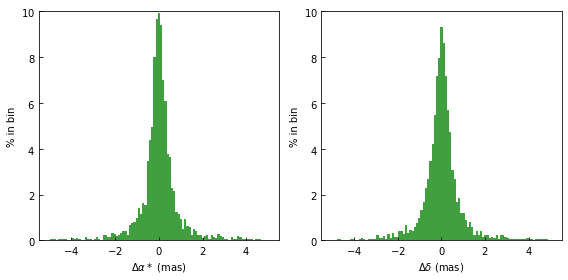

In [8]:
# Difference in RA and decl.
bins_array = np.linspace(-5, 5, 100)
weights = np.ones_like(dRA) * 100. / dRA.size

fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(dRA, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(dDC, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_yticks(np.arange(0, 11, 2))
ax1.set_yticks(np.arange(0, 11, 2))

ax0.set_ylim([0, 10])
ax1.set_ylim([0, 10])

ax0.set_xlabel("$\Delta\\alpha*$ (mas)")
ax1.set_xlabel("$\Delta\\delta$ (mas)")

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

fig.tight_layout()
plt.show()

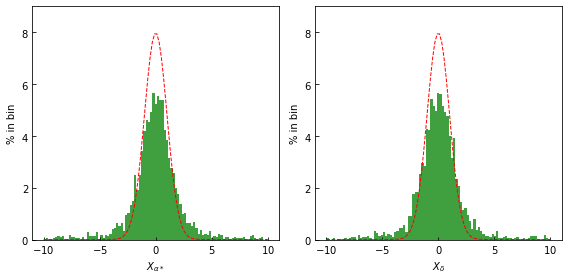

In [9]:
# Normalized difference in RA and decl.
from scipy import stats
bins_array = np.linspace(-10, 10, 100)
weights = np.ones_like(dRA) * 100. / dRA.size

fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(X_a, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(X_d, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_xlabel("$X_{\\alpha*}$")
ax1.set_xlabel("$X_{\\delta}$")

ax0.set_ylim([0, 9])
ax1.set_ylim([0, 9])

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

# add a '(standard) Gaussian distribution' line
Gaussian_dist = stats.norm.pdf(bins_array, 0, 1) * 10. / 50
ax0.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)
ax1.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)

ax0.set_yticks(np.arange(0, 10, 2))
ax1.set_yticks(np.arange(0, 10, 2))

fig.tight_layout()
plt.show()

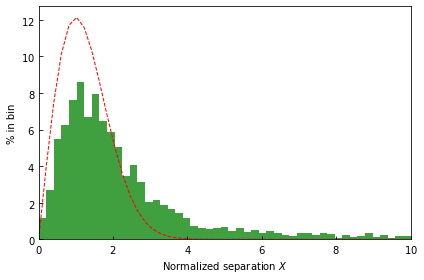

In [10]:
# Distribution of normalized separation
from scipy import stats

bins_array = np.linspace(0, 10, 50)
weights = np.ones_like(X) * 100. / X.size

fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(X, bins_array, weights=weights, facecolor="g", alpha=0.75)

# add a '(standard) Rqyleigh distribution' line
rayleigh_dist = stats.rayleigh.pdf(bins_array) * 10. / 50  * 100
ax.plot(bins_array, rayleigh_dist, "r--", linewidth=1)

ax.set_xlim([0, 10])
ax.set_xlabel("Normalized separation $X$")
ax.set_ylabel("% in bin")

plt.tight_layout()

plt.show()

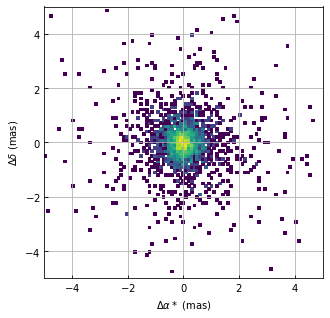

In [11]:
from matplotlib import colors

fig, ax = plt.subplots(figsize=(5, 5))

bins = np.linspace(-5, 5, 100)

# We can increase the number of bins on each axis
ax.hist2d(dRA, dDC, bins, norm=colors.LogNorm())

ax.set_xlabel("$\Delta\\alpha*$ (mas)")
ax.set_ylabel("$\Delta\\delta$ (mas)")

ax.grid(True)

plt.show()

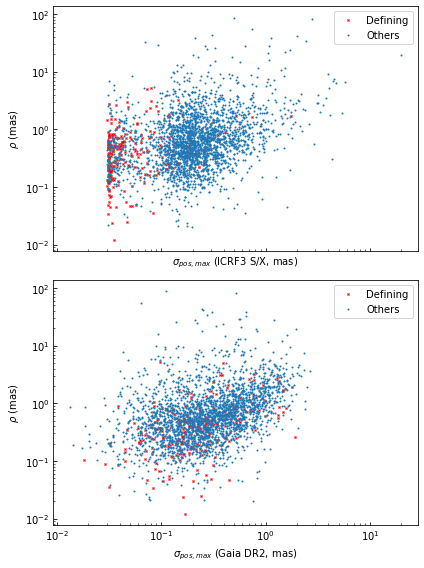

In [13]:
# Angular position difference vs. positional uncertainty
fig, (ax0, ax1) = plt.subplots(figsize=(6, 8), nrows=2, sharex=True)

ax0.plot(com_def["pos_err_icrf3sx"],
         com_def["ang_sep"], "rx", ms=2, label="Defining")
ax1.plot(com_def["pos_err_gaiadr2"],
         com_def["ang_sep"], "rx", ms=2, label="Defining")

ax0.plot(com_oth["pos_err_icrf3sx"],
         com_oth["ang_sep"], ".", ms=2, label="Others")
ax1.plot(com_oth["pos_err_gaiadr2"],
         com_oth["ang_sep"], ".", ms=2, label="Others")

ax0.set_xscale("log")
ax0.set_yscale("log")
ax1.set_xscale("log")
ax1.set_yscale("log")

ax0.set_xlabel("$\sigma_{pos,max}$ (ICRF3 S/X, mas)")
ax0.set_ylabel("$\\rho$ (mas)")
ax1.set_xlabel("$\sigma_{pos,max}$ (Gaia DR2, mas)")
ax1.set_ylabel("$\\rho$ (mas)")


ax0.legend()
ax1.legend()

fig.tight_layout()
plt.show()

Then I investigate the systematics through the 16-parameters transformation.

In [14]:
# Try with all the sources
# Transform columns into np.array
dra = np.array(com_sou["dra"])
ddec = np.array(com_sou["ddec"])
dra_err = np.array(com_sou["dra_err"])
ddec_err = np.array(com_sou["ddec_err"])
ra_rad = np.array(com_sou["ra_icrf3sx"].to(u.radian))
dec_rad = np.array(com_sou["dec_icrf3sx"].to(u.radian))
dra_ddec_cov = np.array(com_sou["dra_ddec_cov"])

# Transformation parameters
# l_max = 1
w1_all, sig1_all, corrcoef1_all = vsh_deg01_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
    cov=dra_ddec_cov, elim_flag="None")

# l_max = 2
w2_all, sig2_all, corrcoef2_all = vsh_deg02_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
    cov=dra_ddec_cov, elim_flag="None")

# mas -> uas
w1 = w1_all * 1.e3
sig1 = sig1_all * 1.e3
w2 = w2_all * 1.e3
sig2 = sig2_all * 1.e3

# Print results
print("Estimates (%6d sources)\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "               Rotation [uas]                 "
      "                  Glide [uas]               \n"
      "               x             y             z"
      "               x             y             z\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "l_max=1  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "l_max=2  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "----------------------------------------------"
      "----------------------------------------------\n" %
      (dra.size, w1[3], sig1[3], w1[4], sig1[4], w1[5], sig1[5],
       w1[0], sig1[0], w1[1], sig1[1], w1[2], sig1[2],
       w2[3], sig2[3], w2[4], sig2[4], w2[5], sig2[5],
       w2[0], sig2[0], w2[1], sig2[1], w2[2], sig2[2]))

quad_names = Column(["ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_quad = Table([quad_names, w2[6:], sig2[6:]], names=["Quadrupolar term", "Estimate", "Error"])
t_quad["Estimate"].format = "%5.0f"
t_quad["Error"].format = "%5.0f"
print(t_quad)

print("Correlation coefficient between parameters in 'l_max=1' fit")
print_vsh1_corr(corrcoef1_all, deci_digit=1, included_one=False)

print("Correlation coefficient between parameters in 'l_max=2' fit")
print_vsh2_corr(corrcoef2_all, deci_digit=1, included_one=False)

Estimates (  2820 sources)
--------------------------------------------------------------------------------------------
               Rotation [uas]                                   Glide [uas]               
               x             y             z               x             y             z
--------------------------------------------------------------------------------------------
l_max=1   +26 +/-  32   -32 +/-  30   -41 +/-  28     -32 +/-  30   +37 +/-  28   +30 +/-  30
l_max=2   +32 +/-  33   -47 +/-  31   -44 +/-  30     -28 +/-  32   +49 +/-  31   +14 +/-  32
--------------------------------------------------------------------------------------------

Quadrupolar term Estimate Error
---------------- -------- -----
            ER22       37    19
            EI22       -3    19
            ER21        9    37
            EI21      -50    40
             E20       41    36
            MR22        2    20
            MI22        1    20
            MR21       26    38
     

In [29]:
# Remove the outlier (consider the normalized separation)
from astropy.table import setdiff
N = len(com_sou)
X0 = np.sqrt(np.log(N) * 2)
# X0 = 3.41

print("There are %d sources.\n"
      "When X >= %.2f, the number of the outlier is smaller than 1." % (N, X0))

mask = ((com_sou["nor_sep"] <= X0)
        & (com_sou["ang_sep"] < 10))

# Table of a clean sample
com_clean = com_sou[mask]
N1 = len(com_clean)
print("After elimination, there are %d sources in the clean sample." % N1)
print("The outlier rate is %.0f%%。" % ((N-N1)/N*100))

# Take a look at the outliers
com_out = setdiff(com_sou, com_clean, keys="iers_name")

print("There are {:d} outliers, among which {:d} are defining sources, "
      "{:d} Other.".format(len(com_out),
                           len(com_out[com_out["type"] == "D"]),
                           len(com_out[com_out["type"] != "D"])))

There are 2820 sources.
When X >= 3.99, the number of the outlier is smaller than 1.
After elimination, there are 2367 sources in the clean sample.
The outlier rate is 16%。
There are 453 outliers, among which 40 are defining sources, 413 Other.


In [16]:
# Transform columns into np.array
dra = np.array(com_clean["dra"])
ddec = np.array(com_clean["ddec"])
dra_err = np.array(com_clean["dra_err"])
ddec_err = np.array(com_clean["ddec_err"])
ra_rad = np.array(com_clean["ra_icrf3sx"].to(u.radian))
dec_rad = np.array(com_clean["dec_icrf3sx"].to(u.radian))
dra_ddec_cov = np.array(com_clean["dra_ddec_cov"])

In [17]:
# Transformation parameters
# l_max = 1
w1_cln, sig1_cln, corrcoef1_cln = vsh_deg01_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
    cov=dra_ddec_cov, elim_flag="None")

# l_max = 2
w2_cln, sig2_cln, corrcoef2_cln = vsh_deg02_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
    cov=dra_ddec_cov, elim_flag="None")

# mas -> uas
w1 = w1_cln * 1.e3
sig1 = sig1_cln * 1.e3
w2 = w2_cln * 1.e3
sig2 = sig2_cln * 1.e3

# Print results
print("Estimates (%6d sources)\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "               Rotation [uas]                 "
      "                  Glide [uas]               \n"
      "               x             y             z"
      "               x             y             z\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "l_max=1  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "l_max=2  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "----------------------------------------------"
      "----------------------------------------------\n" %
      (dra.size, w1[3], sig1[3], w1[4], sig1[4], w1[5], sig1[5],
       w1[0], sig1[0], w1[1], sig1[1], w1[2], sig1[2],
       w2[3], sig2[3], w2[4], sig2[4], w2[5], sig2[5],
       w2[0], sig2[0], w2[1], sig2[1], w2[2], sig2[2]))

quad_names = Column(["ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_quad = Table([quad_names, w2[6:], sig2[6:]], names=["Quadrupolar term", "Estimate", "Error"])
t_quad["Estimate"].format = "%5.0f"
t_quad["Error"].format = "%5.0f"
print(t_quad)

print("Correlation coefficient between parameters in 'l_max=1' fit")
print_vsh1_corr(corrcoef1_cln, deci_digit=1, included_one=False)

print("Correlation coefficient between parameters in 'l_max=2' fit")
print_vsh2_corr(corrcoef2_cln, deci_digit=1, included_one=False)

Estimates (  2367 sources)
--------------------------------------------------------------------------------------------
               Rotation [uas]                                   Glide [uas]               
               x             y             z               x             y             z
--------------------------------------------------------------------------------------------
l_max=1   +18 +/-   8   -19 +/-   7    +3 +/-   7      -8 +/-   7   -11 +/-   7   +14 +/-   7
l_max=2   +22 +/-   8   -24 +/-   8    +3 +/-   7      -9 +/-   8   -14 +/-   8    +5 +/-   8
--------------------------------------------------------------------------------------------

Quadrupolar term Estimate Error
---------------- -------- -----
            ER22        0     5
            EI22        1     4
            ER21        1     9
            EI21       16    10
             E20       34     9
            MR22        4     5
            MI22       -6     5
            MR21        5    10
     

Then I check the residuals of positional offsets.

In [18]:
# Remove the systematics
RA = np.array(com_sou["ra_icrf3sx"].to(u.radian))
DE = np.array(com_sou["dec_icrf3sx"].to(u.radian))

dra_ns, ddec_ns = residual_calc02(dRA, dDC, RA, DE, w2_cln)
# dra_ns, ddec_ns = residual_calc02(dRA, dDC, RA, DE, w2_all)

# Now re-calculate the normalized difference
ang_sep_ns, Xa_ns, Xd_ns, X_ns = nor_sep_calc(
    dra_ns, dRA_err, ddec_ns, dDC_err, dRA_dDC_cov/dRA_err/dDC_err)

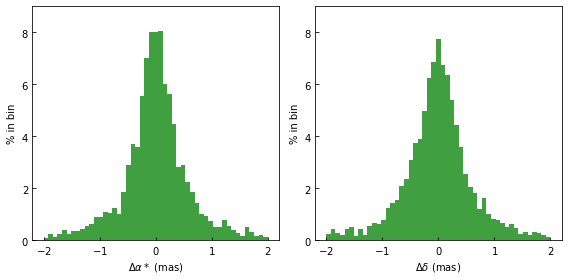

In [19]:
# Difference in RA and decl.
bins_array = np.linspace(-2, 2, 50)
weights = np.ones_like(dra_ns) * 100. / dra_ns.size

fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(dra_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(ddec_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_yticks(np.arange(0, 10, 2))
ax1.set_yticks(np.arange(0, 10, 2))

ax0.set_ylim([0, 9])
ax1.set_ylim([0, 9])

ax0.set_xlabel("$\Delta\\alpha*$ (mas)")
ax1.set_xlabel("$\Delta\\delta$ (mas)")

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

fig.tight_layout()
plt.show()

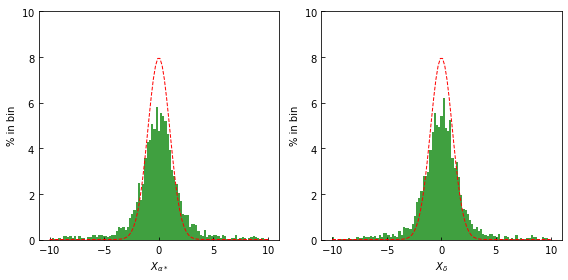

In [20]:
# Normalized difference in RA and decl.
from scipy import stats
bins_array = np.linspace(-10, 10, 100)
weights = np.ones_like(Xa_ns) * 100. / Xa_ns.size

# Plot the 
fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(Xa_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(Xd_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_xlabel("$X_{\\alpha*}$")
ax1.set_xlabel("$X_{\\delta}$")

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

# add a '(standard) Gaussian distribution' line
Gaussian_dist = stats.norm.pdf(bins_array, 0, 1) * 10. / 50
ax0.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)
ax1.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)

ax0.set_yticks(np.arange(0, 11, 2))
ax1.set_yticks(np.arange(0, 11, 2))

fig.tight_layout()
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

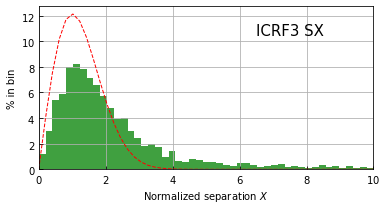

In [21]:
# Distribution of normalized separation
from scipy import stats

bins_array = np.linspace(0, 10, 50)
weights = np.ones_like(X_ns) * 100. / X_ns.size

fig, ax = plt.subplots(figsize=(6, 3))
ax.hist(X_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)

# add a '(standard) Rqyleigh distribution' line
rayleigh_dist = stats.rayleigh.pdf(bins_array) * 10. / 50  * 100
ax.plot(bins_array, rayleigh_dist, "r--", linewidth=1)

ax.text(6.5, 10.5, "ICRF3 SX", fontsize=15)

ax.set_xlim([0, 10])
ax.set_xlabel("Normalized separation $X$")
ax.set_ylabel("% in bin")
ax.grid()

plt.savefig("../plots/x_icrf3sx_gaiadr2.eps")

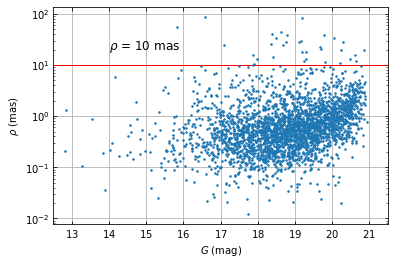

In [24]:
# Distribution of angular separation
fig, ax = plt.subplots()
ax.plot(com_sou["phot_g_mean_mag"], com_sou["ang_sep"], ".", ms=3)
ax.hlines(10, 12.5, 21.5, "r", lw=1)

ax.text(14, 20, "$\\rho$ = 10 mas", fontsize=12)

ax.set_xlim([12.5, 21.5])

ax.set_ylabel("$\\rho$ (mas)")
ax.set_xlabel("$G$ (mag)")

ax.set_yscale("log")

ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")

ax.grid()
plt.savefig("../plots/angsep-g_icrf3sx_gaiadr2.eps")

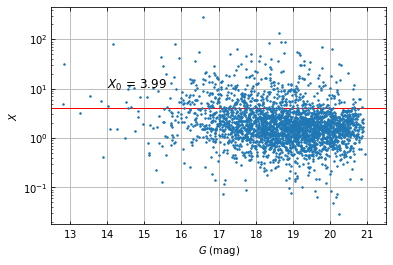

In [25]:
# Distribution of angular separation
fig, ax = plt.subplots()
ax.plot(com_sou["phot_g_mean_mag"], com_sou["nor_sep"], ".", ms=3)
ax.hlines(X0, 12.5, 21.5, "r", lw=1)

ax.text(14, 10, "$X_0$ = {:.2f}".format(X0), fontsize=12)

ax.set_xlim([12.5, 21.5])
ax.set_ylabel("$X$")
ax.set_xlabel("$G$ (mag)")

ax.set_yscale("log")

ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")

ax.grid()
plt.savefig("../plots/norsep-g_icrf3sx_gaiadr2.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


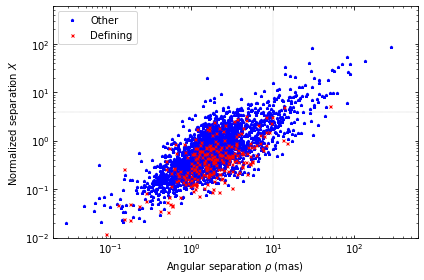

In [22]:
# Angular separation vs. normalized separation
fig, ax = plt.subplots()

ax.plot(com_oth["nor_sep"], com_oth["ang_sep"], "b*", ms=3, label="Other")
ax.plot(com_def["nor_sep"], com_def["ang_sep"], "rx", ms=3, label="Defining")
ax.vlines(10, 0.01, 600, colors="k", linestyles="dashed", lw=0.1)
ax.hlines(X0, 0.02, 600, colors="k", linestyles="dashed", lw=0.1)

ax.set_ylabel("Normalized separation $X$")
ax.set_xlabel("Angular separation $\\rho$ (mas)")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlim([0.02, 600])
ax.set_ylim([0.01, 600])

ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")

ax.legend(loc="upper left")
fig.tight_layout()


plt.savefig("../plots/separation_icrf3sx_gaiadr2.eps")

Save the results for future use.

In [23]:
# The last step is to save the 16 transformation parameters for further use.
# Transformation parameters using the whole sample
vsh2_names = Column(["D1", "D2", "D3",
                     "R1", "R2", "R3",
                     "ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_vsh2 = Table([vsh2_names, w2_all*1e3, sig2_all*1e3], names=[
               "Names", "Estimate", "Error"])
t_vsh2["Estimate"].format = "%5.0f"
t_vsh2["Error"].format = "%5.0f"
t_vsh2["Estimate"].unit = u.uas
t_vsh2["Error"].unit = u.uas
t_vsh2.write("../logs/icrf3sx_gaiadr2_vsh02_all.log",
             format="ascii", overwrite=True)

# Transformation parameters using the clean sample
vsh2_names = Column(["D1", "D2", "D3",
                     "R1", "R2", "R3",
                     "ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_vsh2 = Table([vsh2_names, w2, sig2], names=[
               "Names", "Estimate", "Error"])
t_vsh2["Estimate"].format = "%5.0f"
t_vsh2["Error"].format = "%5.0f"
t_vsh2["Estimate"].unit = u.uas
t_vsh2["Error"].unit = u.uas
t_vsh2.write("../logs/icrf3sx_gaiadr2_vsh02.log",
             format="ascii", overwrite=True)

In [30]:
# Remove the outlier (consider the normalized separation)
mask = ((X_ns <= X0)
        & (ang_sep_ns < 10))

# Table of a clean sample
com_clean = com_sou[mask]
N1 = len(com_clean)
print("After elimination, there are %d sources in the clean sample." % N1)
print("The outlier rate is %.0f%%。" % ((N-N1)/N*100))

# Take a look at the outliers
from astropy.table import setdiff
com_out = setdiff(com_sou, com_clean, keys="iers_name")

print("There are {:d} outliers, among which {:d} are defining sources, "
      "{:d} Other.".format(len(com_out),
                           len(com_out[com_out["type"] == "D"]),
                           len(com_out[com_out["type"] != "D"])))

After elimination, there are 2370 sources in the clean sample.
The outlier rate is 16%。
There are 450 outliers, among which 38 are defining sources, 412 Other.
